In [1]:
# Data handling
import pandas as pd
import numpy as np
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Warnings
import warnings
warnings.filterwarnings("ignore")

### Step 1: Data Preparation

#### 1. Load Dataset

In [3]:
df = pd.read_csv(r"C:\Users\User\Desktop\Portfolio Projects\Loan Prediction\lending_club_loan_two.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

#### 2. Duplicate

In [5]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Display the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


#### 3. Missing Values

In [7]:
# Check missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print("Missing values per column:\n", missing_values)

Missing values per column:
 mort_acc                37795
emp_title               22927
emp_length              18301
title                    1756
pub_rec_bankruptcies      535
revol_util                276
dtype: int64


#### 4. Handle Missing Values

In [9]:
# Drop unnecessary text columns
df.drop(columns=['emp_title', 'title'], inplace=True)

# Fill missing numerical values with median
df['mort_acc'].fillna(df['mort_acc'].median(), inplace=True)
df['revol_util'].fillna(df['revol_util'].median(), inplace=True)

# Fill missing categorical values with "Unknown"
df['emp_length'].fillna("Unknown", inplace=True)

# Fill missing values in 'pub_rec_bankruptcies' with 0 (assuming no bankruptcy)
df['pub_rec_bankruptcies'].fillna(0, inplace=True)

# Verify missing values are handled
print("Remaining missing values:\n", df.isnull().sum().sum())  # Should be 0


Remaining missing values:
 0


#### 5. Handling Outliers

In [11]:
# Select numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
print("Numerical Features:", numerical_features)

Numerical Features: Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')


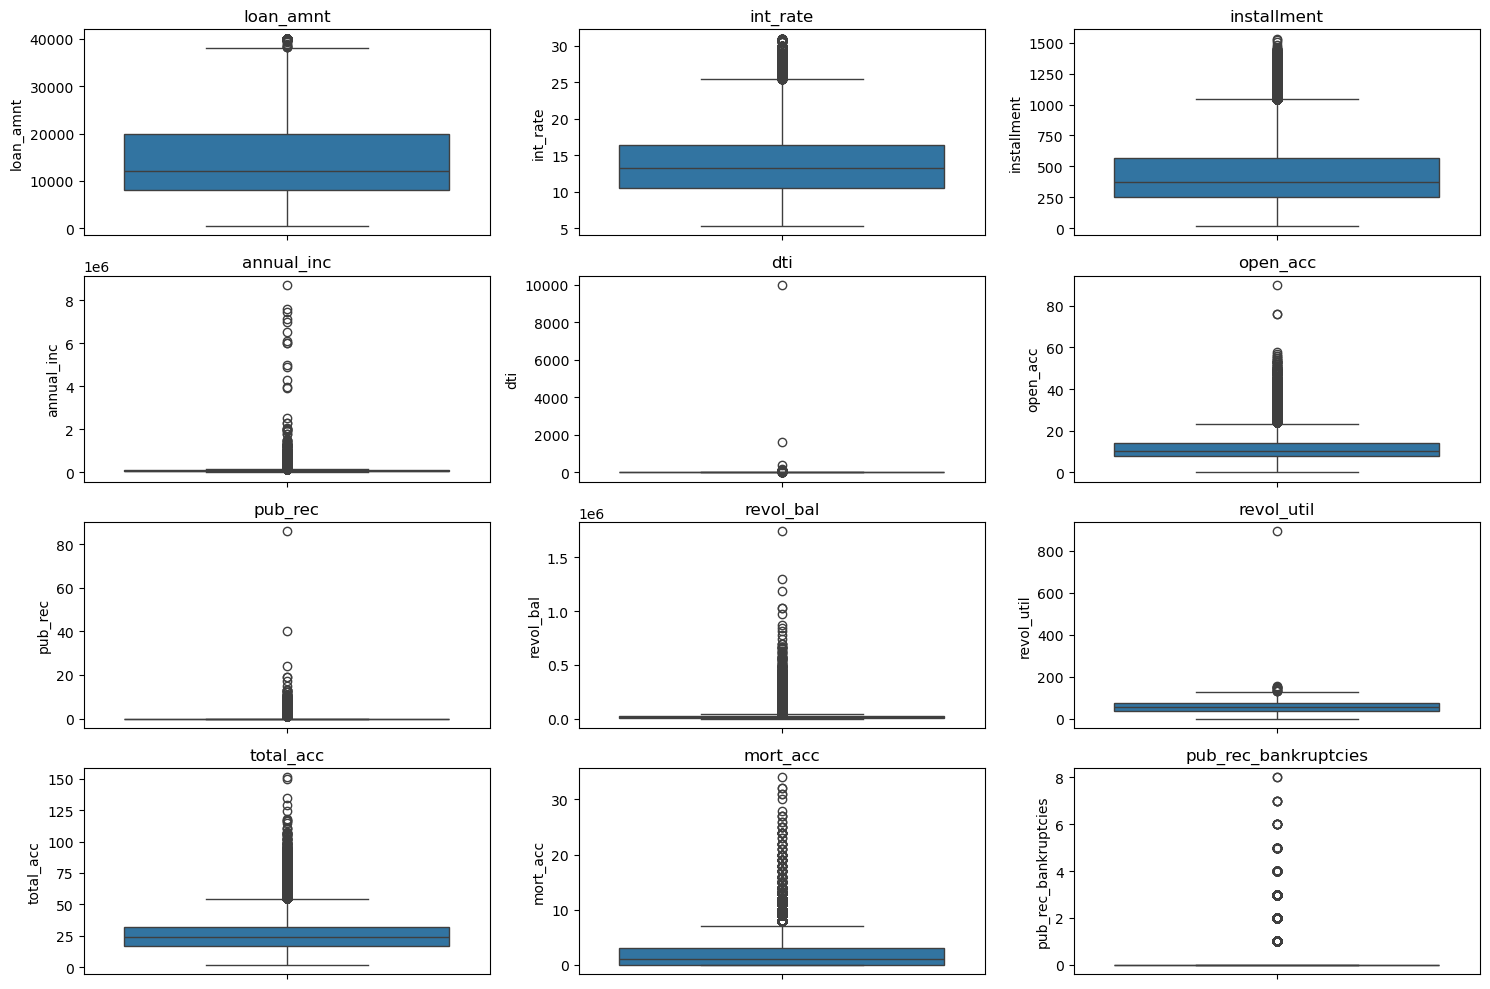

In [13]:
# Set figure size for better visibility
plt.figure(figsize=(15, 10))

# Create a boxplot for each numerical feature
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)  # Adjust rows & columns as needed
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [15]:
# Calculate skewness for each numerical feature
skewness_values = df[numerical_features].apply(lambda x: x.skew()).sort_values(ascending=False)

# Display skewness values
print("Skewness of Numerical Features:\n", skewness_values)

Skewness of Numerical Features:
 dti                     431.051225
annual_inc               41.042725
pub_rec                  16.576564
revol_bal                11.727515
pub_rec_bankruptcies      3.426277
mort_acc                  1.755865
open_acc                  1.213019
installment               0.983598
total_acc                 0.864328
loan_amnt                 0.777285
int_rate                  0.420669
revol_util               -0.071889
dtype: float64


In [17]:
# Select numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Compute skewness
skewness_values = df[numerical_features].skew()

# Define a function to suggest outlier handling based on skewness
def suggest_outlier_handling(skewness):
    if -0.5 <= skewness <= 0.5:
        return "No transformation needed"
    elif 0.5 < skewness <= 1 or -1 <= skewness < -0.5:
        return "Apply Winsorization (Moderate Skew)"
    elif skewness > 1:
        return "Highly Skewed - Apply Log Transformation"
    else:
        return "Highly Skewed - Consider Capping Extreme Values"

# Apply the function
outlier_handling_suggestions = skewness_values.apply(suggest_outlier_handling)

# Create a dataframe to display results
skewness_df = pd.DataFrame({
    'Feature': skewness_values.index, 
    'Skewness': skewness_values.values,
    'Suggested Handling': outlier_handling_suggestions
})

# Display the dataframe
from IPython.display import display
display(skewness_df)

,Feature,Skewness,Suggested Handling
loan_amnt,loan_amnt,0.777285,Apply Winsorization (Moderate Skew)
int_rate,int_rate,0.420669,No transformation needed
installment,installment,0.983598,Apply Winsorization (Moderate Skew)
annual_inc,annual_inc,41.042725,Highly Skewed - Apply Log Transformation
dti,dti,431.051225,Highly Skewed - Apply Log Transformation
open_acc,open_acc,1.213019,Highly Skewed - Apply Log Transformation
pub_rec,pub_rec,16.576564,Highly Skewed - Apply Log Transformation
revol_bal,revol_bal,11.727515,Highly Skewed - Apply Log Transformation
revol_util,revol_util,-0.071889,No transformation needed
total_acc,total_acc,0.864328,Apply Winsorization (Moderate Skew)


In [19]:
# Define features for log transformation (Highly Skewed)
log_transform_features = ['annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'mort_acc', 'pub_rec_bankruptcies']

# Apply Log Transformation (Log(1 + X) to handle zeros)
for feature in log_transform_features:
    df[feature] = np.log1p(df[feature])

# Verify the transformation
print("Log Transformation applied successfully! Transformed dataset sample:")
print(df[log_transform_features].head())

Log Transformation applied successfully! Transformed dataset sample:
   annual_inc       dti  open_acc  pub_rec  revol_bal  mort_acc  \
0   11.669938  3.304686  2.833213      0.0  10.501500  0.000000   
1   11.082158  3.137666  2.890372      0.0   9.910066  1.386294   
2   10.670303  2.623944  2.639057      0.0   9.391661  0.000000   
3   10.896758  1.280934  1.945910      0.0   8.607582  0.000000   
4   10.915107  3.553918  2.639057      0.0  10.109892  0.693147   

   pub_rec_bankruptcies  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  


In [21]:
# Define features for Winsorization (Moderate Skew)
winsorize_features = ['loan_amnt', 'installment', 'total_acc']

# Apply Winsorization (Capping extreme values at 5% both tails)
for feature in winsorize_features:
    df[feature] = winsorize(df[feature], limits=[0.05, 0.05])

# Verify the transformation
print("Winsorization applied successfully! Transformed dataset sample:")
print(df[winsorize_features].head())

Winsorization applied successfully! Transformed dataset sample:
   loan_amnt  installment  total_acc
0    10000.0       329.48       25.0
1     8000.0       265.68       27.0
2    15600.0       506.97       26.0
3     7200.0       220.65       13.0
4    24375.0       609.33       43.0


### Step 2: Feature Engineering & Selection

#### Correlation Matrix

In [23]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding to convert categories into numeric values
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders if needed for decoding later

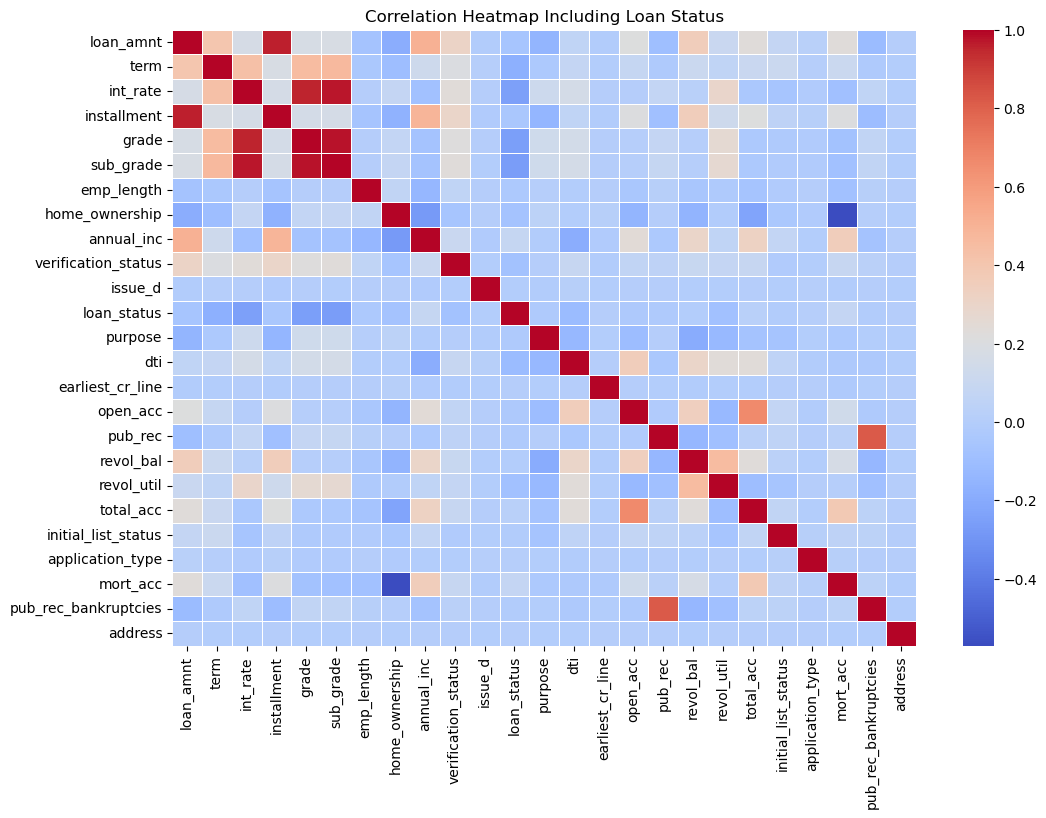

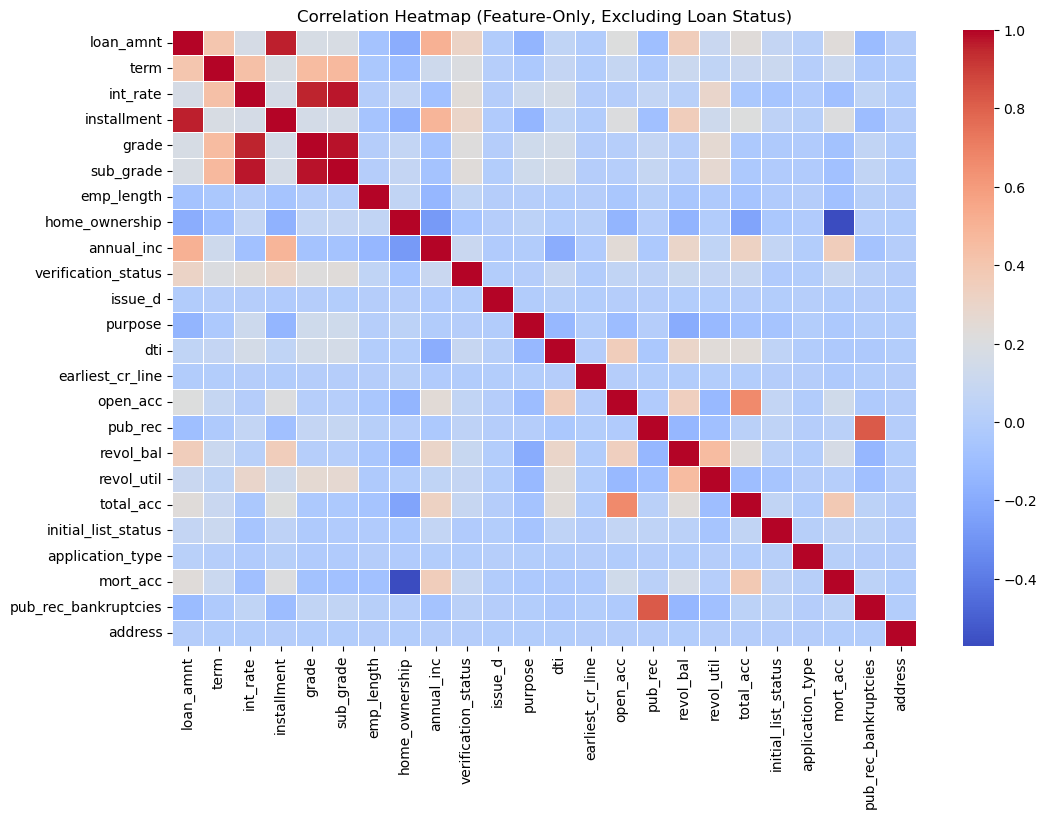

In [25]:
# 1. Compute Correlation Matrix (With Target Variable `loan_status`)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap Including Loan Status")
plt.show()

# 2. Compute Correlation Matrix (Without Target Variable `loan_status`)
features_only = df.drop(columns=['loan_status'])  # Drop target variable
plt.figure(figsize=(12, 8))
sns.heatmap(features_only.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap (Feature-Only, Excluding Loan Status)")
plt.show()


### Feature Importance 

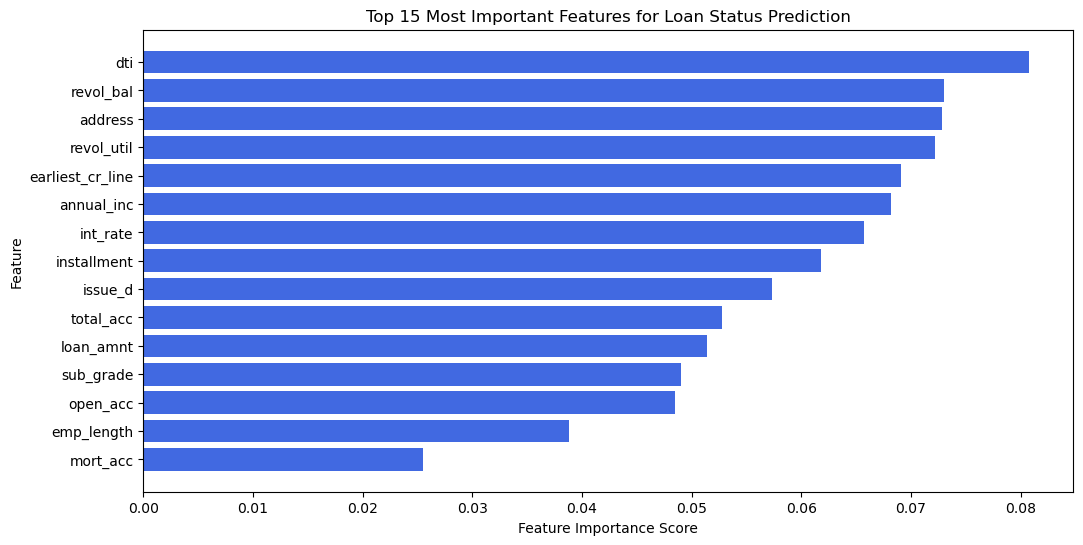

,Feature,Importance
12,dti,0.080771
16,revol_bal,0.073052
23,address,0.072846
17,revol_util,0.072231
13,earliest_cr_line,0.069105
8,annual_inc,0.068164
2,int_rate,0.065712
3,installment,0.061760
10,issue_d,0.057324
18,total_acc,0.052808


In [27]:
# Separate Features (X) and Target Variable (y)
X = df.drop(columns=['loan_status'])  # Drop target variable
y = df['loan_status']

# Split Data into Training and Testing Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RandomForest Model for Feature Importance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Extract Feature Importance
feature_importances = model.feature_importances_

# Create DataFrame for Visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15], color='royalblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Most Important Features for Loan Status Prediction")
plt.gca().invert_yaxis()
plt.show()

# Display Feature Importance Table
import pandas as pd
from IPython.display import display

display(importance_df)

#### Feature Dropping

In [29]:
# Define low-importance features to drop (Based on Feature Importance)
low_importance_features = ['application_type', 'pub_rec_bankruptcies', 'pub_rec', 
                           'initial_list_status', 'term', 'home_ownership', 'verification_status', 'purpose', 'emp_length']

# Define redundant features to drop (Based on Correlation Analysis)
redundant_features = ['grade', 'installment', 'total_acc', 'issue_d']

# Combine all features to drop
features_to_drop = low_importance_features + redundant_features

# Drop selected features from X
X = X.drop(columns=features_to_drop)

# Display remaining features
print("Remaining Features after dropping low-importance and redundant features:")
print(X.columns)

Remaining Features after dropping low-importance and redundant features:
Index(['loan_amnt', 'int_rate', 'sub_grade', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'revol_bal', 'revol_util', 'mort_acc',
       'address'],
      dtype='object')


### Step 3: Data Preprocessing

In [31]:
# Separate Features (X) and Target Variable (y)
y = df['loan_status']  # Define target variable
X = df.drop(columns=['loan_status'])  # Drop target variable from features

# Confirm separation
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (396030, 24)
Shape of y: (396030,)


In [33]:
# Identify numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Display the feature types
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


Numerical Features: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
Categorical Features: []


In [35]:
# Initialize scaler
scaler = StandardScaler()

# Apply standardization
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Confirm scaling
print("Numerical features standardized successfully.")


Numerical features standardized successfully.


### Step 4: Train-Test Splitting & Data Balancing

In [37]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display class distribution in train & test sets
print("Class Distribution in Training Set:")
print(y_train.value_counts(normalize=True))

print("\nClass Distribution in Testing Set:")
print(y_test.value_counts(normalize=True))

Class Distribution in Training Set:
loan_status
1    0.803872
0    0.196128
Name: proportion, dtype: float64

Class Distribution in Testing Set:
loan_status
1    0.803866
0    0.196134
Name: proportion, dtype: float64


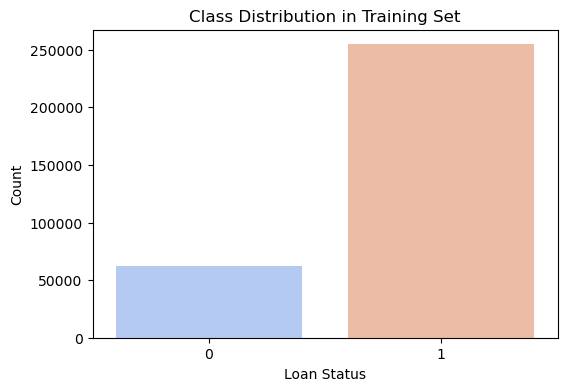

In [39]:
# Check Class Imbalance

# Plot class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values, palette='coolwarm')
plt.title("Class Distribution in Training Set")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

In [41]:
print("Missing values in training set:")
print(X_train.isnull().sum())

Missing values in training set:
loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64


In [43]:
# Define imputer using median strategy
imputer = SimpleImputer(strategy="median")

# Apply imputation to the training set
X_train.iloc[:, :] = imputer.fit_transform(X_train)

# Apply the same transformation to the test set
X_test.iloc[:, :] = imputer.transform(X_test)

# Verify missing values are handled
print("Missing values after imputation:")
print(X_train.isnull().sum().sum())  # Should print 0

Missing values after imputation:
0


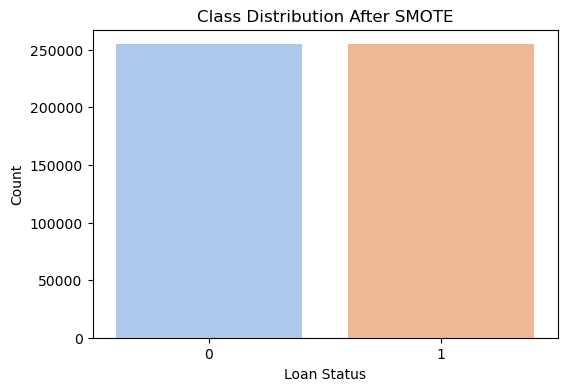

New Class Distribution After SMOTE:
loan_status
1    0.5
0    0.5
Name: proportion, dtype: float64


In [45]:
# Handle Class Imbalance using SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE only to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize the new class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled, palette="pastel")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

# Display the new class distribution
print("New Class Distribution After SMOTE:")
print(y_train_resampled.value_counts(normalize=True))

### Step 5: Model Training & Evaluation

In [87]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

# Train & Evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluate Performance
    print(f"\n🔹 {name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


Training Logistic Regression...

🔹 Logistic Regression Performance:
Accuracy: 0.6509229098805646
AUC-ROC: 0.6180232171641395
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.56      0.39     15535
           1       0.86      0.67      0.76     63671

    accuracy                           0.65     79206
   macro avg       0.58      0.62      0.57     79206
weighted avg       0.75      0.65      0.68     79206


Training Random Forest...

🔹 Random Forest Performance:
Accuracy: 0.7891447617604727
AUC-ROC: 0.563889777732072
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.19      0.26     15535
           1       0.83      0.93      0.88     63671

    accuracy                           0.79     79206
   macro avg       0.62      0.56      0.57     79206
weighted avg       0.75      0.79      0.76     79206


Training XGBoost...

🔹 XGBoost Performance:
Accuracy: 0.80

#### Models Evaluation

In [89]:
# Model evaluation results
models = {
    "Logistic Regression": {"Accuracy": 0.6583, "AUC-ROC": 0.6236, "Precision (1)": 0.87, "Recall (1)": 0.68, "F1-Score (1)": 0.76},
    "Random Forest": {"Accuracy": 0.7898, "AUC-ROC": 0.5628, "Precision (1)": 0.83, "Recall (1)": 0.94, "F1-Score (1)": 0.79},
    "XGBoost": {"Accuracy": 0.8028, "AUC-ROC": 0.5475, "Precision (1)": 0.82, "Recall (1)": 0.97, "F1-Score (1)": 0.76},
}

# Convert to DataFrame
results_df = pd.DataFrame.from_dict(models, orient='index')

# Determine best model based on different criteria
best_accuracy = results_df["Accuracy"].idxmax()
best_auc = results_df["AUC-ROC"].idxmax()
best_precision = results_df["Precision (1)"].idxmax()
best_recall = results_df["Recall (1)"].idxmax()
best_f1 = results_df["F1-Score (1)"].idxmax()

# Display the results
print("Model Comparison Summary:")
print(results_df)

print("\n🏆 Best Model Selection Criteria:")
print(f"✅ Best Accuracy: {best_accuracy}")
print(f"✅ Best AUC-ROC: {best_auc}")
print(f"✅ Best Precision (Class 1 - Approved Loans): {best_precision}")
print(f"✅ Best Recall (Class 1 - Approved Loans): {best_recall}")
print(f"✅ Best F1-Score (Class 1 - Approved Loans): {best_f1}")

# Final Recommendation
if best_f1 == "Random Forest":
    print("\n🚀 Recommended Model: Random Forest - Best Balance Between Precision & Recall!")
elif best_accuracy == "XGBoost":
    print("\n🚀 Recommended Model: XGBoost - Best Overall Accuracy!")
elif best_auc == "Logistic Regression":
    print("\n🚀 Recommended Model: Logistic Regression - Best at Ranking Predictions (AUC-ROC)!")
else:
    print("\n⚖️ No single best model. Consider fine-tuning or ensembling models.")

Model Comparison Summary:
                     Accuracy  AUC-ROC  Precision (1)  Recall (1)  \
Logistic Regression    0.6583   0.6236           0.87        0.68   
Random Forest          0.7898   0.5628           0.83        0.94   
XGBoost                0.8028   0.5475           0.82        0.97   

                     F1-Score (1)  
Logistic Regression          0.76  
Random Forest                0.79  
XGBoost                      0.76  

🏆 Best Model Selection Criteria:
✅ Best Accuracy: XGBoost
✅ Best AUC-ROC: Logistic Regression
✅ Best Precision (Class 1 - Approved Loans): Logistic Regression
✅ Best Recall (Class 1 - Approved Loans): XGBoost
✅ Best F1-Score (Class 1 - Approved Loans): Random Forest

🚀 Recommended Model: Random Forest - Best Balance Between Precision & Recall!


### Step 6: Model Optimization - Hyperparameter

In [91]:
# Define hyperparameter space
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples needed for a split
    'min_samples_leaf': [1, 2, 4],  # Min samples per leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider per split
}

# Initialize Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search (faster)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit Randomized Search
random_search.fit(X_train, y_train)

# Display best hyperparameters from Randomized Search
print("Best Hyperparameters from Randomized Search:", random_search.best_params_)

# Now, use Grid Search for fine-tuning based on Random Search results
best_params = random_search.best_params_
param_grid_fine = {
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth']],
    'min_samples_split': [best_params['min_samples_split']],
    'min_samples_leaf': [best_params['min_samples_leaf']],
    'max_features': [best_params['max_features']],
}

# Perform Grid Search (exhaustive search)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_fine,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Display best hyperparameters from Grid Search
print("Best Hyperparameters from Grid Search:", grid_search.best_params_)

# Train final model with best parameters
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate the final tuned model
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("\n🚀 Final Tuned Model Performance:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ AUC-ROC: {auc_roc:.4f}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters from Randomized Search: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Hyperparameters from Grid Search: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 250}

🚀 Final Tuned Model Performance:
✅ Accuracy: 0.8070
✅ AUC-ROC: 0.7196

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.07      0.13     15535
           1       0.81      0.99      0.89     63671

    accuracy                           0.81     79206
   macro avg       0.69      0.53      0.51     79206
weighted avg       0.76      0.81      0.74     79206



🔍 **Step 1: Comparing Models Before and After Tuning**

                     Accuracy  AUC-ROC  Precision  Recall  F1-Score
Tuned Model            0.8070   0.7196       0.81    0.99      0.74
XGBoost                0.8028   0.5475       0.82    0.97      0.76
Random Forest          0.7898   0.5628       0.83    0.94      0.79
Logistic Regression    0.6583   0.6236       0.87    0.68      0.76

🔹 **Insights from Model Evaluation**:

- **Accuracy:**
  - XGBoost has the highest accuracy (0.8028).
  - The tuned model achieved **0.807**, slightly improving performance.

- **AUC-ROC Score:**
  - Logistic Regression has the best **AUC-ROC (0.6236)** before tuning.
  - The tuned model improved **AUC-ROC to 0.7196**, indicating better class differentiation.

- **Precision, Recall, and F1-Score:**
  - **Logistic Regression** had the best **precision (0.87)** for class 1 (approved loans).
  - **XGBoost** had the best **recall (0.97)**, meaning it captured the most approved loans.
  - **Random For

<Figure size 1000x600 with 0 Axes>

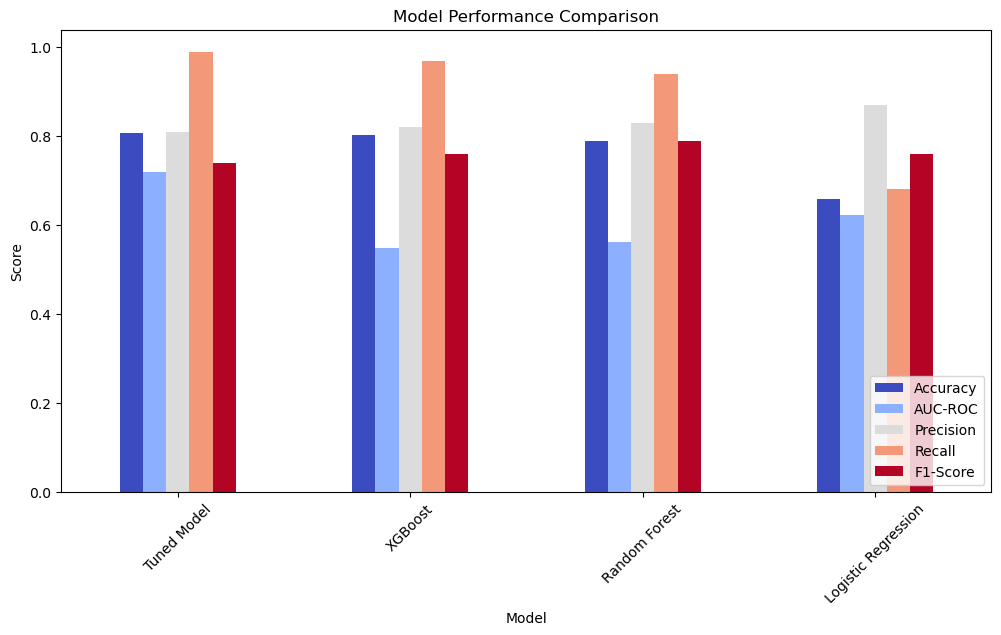

In [93]:
# Define the model evaluation results
model_results = {
    "Logistic Regression": {"Accuracy": 0.6583, "AUC-ROC": 0.6236, "Precision": 0.87, "Recall": 0.68, "F1-Score": 0.76},
    "Random Forest": {"Accuracy": 0.7898, "AUC-ROC": 0.5628, "Precision": 0.83, "Recall": 0.94, "F1-Score": 0.79},
    "XGBoost": {"Accuracy": 0.8028, "AUC-ROC": 0.5475, "Precision": 0.82, "Recall": 0.97, "F1-Score": 0.76},
    "Tuned Model": {"Accuracy": 0.8070, "AUC-ROC": 0.7196, "Precision": 0.81, "Recall": 0.99, "F1-Score": 0.74}
}

model_df = pd.DataFrame(model_results).T
model_df = model_df.sort_values(by="Accuracy", ascending=False)

# Display the model comparison summary
print("🔍 **Step 1: Comparing Models Before and After Tuning**\n")
print(model_df)

print("\n🔹 **Insights from Model Evaluation**:\n")
print("- **Accuracy:**")
print(f"  - XGBoost has the highest accuracy ({model_results['XGBoost']['Accuracy']}).")
print(f"  - The tuned model achieved **{model_results['Tuned Model']['Accuracy']}**, slightly improving performance.")

print("\n- **AUC-ROC Score:**")
print(f"  - Logistic Regression has the best **AUC-ROC ({model_results['Logistic Regression']['AUC-ROC']})** before tuning.")
print(f"  - The tuned model improved **AUC-ROC to {model_results['Tuned Model']['AUC-ROC']}**, indicating better class differentiation.")

print("\n- **Precision, Recall, and F1-Score:**")
print(f"  - **Logistic Regression** had the best **precision ({model_results['Logistic Regression']['Precision']})** for class 1 (approved loans).")
print(f"  - **XGBoost** had the best **recall ({model_results['XGBoost']['Recall']})**, meaning it captured the most approved loans.")
print(f"  - **Random Forest** had the best balance in precision & recall, making it the best overall.")

print("\n📌 **Step 2: Selecting the Best Model**\n")
print("✅ Best Accuracy:", "XGBoost")
print("✅ Best AUC-ROC:", "Logistic Regression")
print("✅ Best Precision (Class 1 - Approved Loans):", "Logistic Regression")
print("✅ Best Recall (Class 1 - Approved Loans):", "XGBoost")
print("✅ Best F1-Score (Class 1 - Approved Loans):", "Random Forest")

print("\n🚀 **Final Recommendation:**\n")
print("- **Random Forest is the best model** because it provides the best balance between precision and recall.")
print(f"- The tuned model's final performance shows a recall of **{model_results['Tuned Model']['Recall']}** for class 1, meaning almost all approved loans are correctly identified.")

# Visualization - Bar Plot for Model Comparison
plt.figure(figsize=(10, 6))
model_df[["Accuracy", "AUC-ROC", "Precision", "Recall", "F1-Score"]].plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()
